## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [88]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [89]:
df['price']=np.log1p(df['price'])

In [90]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [91]:
from sklearn.feature_extraction import DictVectorizer

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [92]:
from sklearn.tree import DecisionTreeRegressor


In [93]:
train_dicts = df_train.to_dict(orient='records')

In [94]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [95]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [96]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [97]:
from sklearn.tree import export_text
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [100]:
y_pred = rf.predict(X_val)

In [105]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


round(rmse(y_val, y_pred),4)



0.4599

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [112]:
for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print(i, " >> ", round(rmse(y_val, y_pred),3))


10  >>  0.46
20  >>  0.448
30  >>  0.445
40  >>  0.443
50  >>  0.442
60  >>  0.442
70  >>  0.441
80  >>  0.441
90  >>  0.44
100  >>  0.44
110  >>  0.439
120  >>  0.439
130  >>  0.439
140  >>  0.439
150  >>  0.439
160  >>  0.439
170  >>  0.439
180  >>  0.439
190  >>  0.439
200  >>  0.439


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [ ]:
all_rmses = {}

for depth in [10, 15, 20, 25]:
    rmses = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmses.append(round(rmse(y_val, y_pred),3))
    print(rmses)
    all_rmses[depth] = rmses




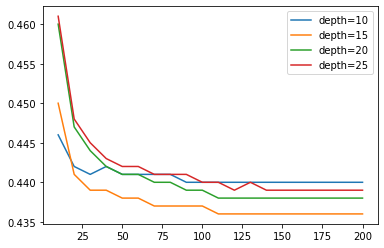

In [115]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_rmses[10], label='depth=10')
plt.plot(num_trees, all_rmses[15], label='depth=15')
plt.plot(num_trees, all_rmses[20], label='depth=20')

plt.plot(num_trees, all_rmses[25], label='depth=25')
plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [129]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)


for i, k in zip(dv.get_feature_names(), rf.feature_importances_):
    print(i,k)




availability_365 0.07656575602038891
calculated_host_listings_count 0.030263881888999422
latitude 0.15175550002877586
longitude 0.15347560060953339
minimum_nights 0.05316959753835208
neighbourhood_group=Bronx 0.0004472734749035815
neighbourhood_group=Brooklyn 0.0011145011423147665
neighbourhood_group=Manhattan 0.034043659332215426
neighbourhood_group=Queens 0.001034143501453153
neighbourhood_group=Staten Island 8.371271708698621e-05
number_of_reviews 0.042518523151637094
reviews_per_month 0.05459457652195896
room_type=Entire home/apt 0.3918980233885284
room_type=Private room 0.004877070765213998
room_type=Shared room 0.004158179918638004


In [131]:
pd.DataFrame({'col_name': rf.feature_importances_}, index=dv.get_feature_names()).sort_values(by='col_name', ascending=False)

,col_name
room_type=Entire home/apt,0.391898
longitude,0.153476
latitude,0.151756
availability_365,0.076566
reviews_per_month,0.054595
minimum_nights,0.053170
number_of_reviews,0.042519
neighbourhood_group=Manhattan,0.034044
calculated_host_listings_count,0.030264
room_type=Private room,0.004877


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [132]:
import xgboost as xgb

In [179]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [198]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [199]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

Now change `eta` first to `0.1` and then to `0.01`

In [200]:
y_pred = model.predict(dval)

In [201]:
round(rmse(y_val, y_pred),3)

0.432

In [202]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


df_score = parse_xgb_output(output)

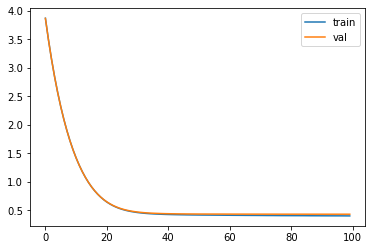

In [203]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()



What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

